In [20]:
%%capture
!pip install datasets

%matplotlib inline

import os
import re
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import Dataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.functional import cross_entropy, mse_loss
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel, GPT2Model, GPT2Config, AutoTokenizer

from tokenizers import (
    decoders,
    models,
    processors,
    Tokenizer,
    pre_tokenizers,
)

In [2]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/NN/data'

Mounted at /content/drive


This is an example of what we have inside of it:

`{'description':{'planet0':{'m':1.3125619386712204,'a':1.944262696822503,'e':1.89780665411419} `

As we can see from the previous sample, the Dataset, which is composed with few keys and a lot of numbers has a Dictionary-like structure. Each row in our Dataset has a variable length and represent a REBOUND simulation. Each simulation is composed by some planet (at least 2) and all of them are described by 3 main attributes: mass <font color='orange'>m</font>, eccentricity <font color='orange'>e</font> and the length of the major semi-axis <font color='orange'>a</font>. We have other numerical values that defines the planetary orbit simulation after the key-word <font color='orange'>data</font>.
The Dataset have been imported using the Hugging Face's library <font color='olive'>datasets</font> and all the previous information have been extrapolated by analyzing the keys of each sample and their number of occurrences.
Since we have found out that this Dataset has 11 recurrent words and we are interested in the numerical representation, we can describe it by using <font color='yellow'>30 tokens</font>.





### Description of the Implementation:


This project aim was to reproduce the tokenization technique proposed in the paper <font color='orange'>***“xVal : A Continuous Number Encoding for Large Language Models”***</font>.
XVal embeds all numerical values along a specific learnable direction of the embedding space. Given a string composed by text and numbers, all numerical values will be extracted and collected inside a separate list. The string will be modified by replacing all the numbers with the same token <font color='yellow'>[NUM]</font>, which will act as a placeholder. We focus to imp

# Import Data:

From all the Datasets proposed by the authors of the paper, I have chosen the one related to planetary motion. This is a synthetic Dataset, which is composed by some planetary simulations generated by the <font color='olive'>REBOUND</font> library.
The Dataset have been obtained by using the code provided by the authors of the repository. Each Dataset partition have been saved into a file inside Google Drive.

In [3]:
"""
All data are obtained through a simulation that uses REBOUND library
training_data a list composed by 300k sublists
Each sublists has a variable number of samples
"""
training_data = Dataset.from_text(drive_path + '/training')
test_data = Dataset.from_text(drive_path + '/test')


print(training_data)
print('\n')
print(training_data.info)
print('\n')
print(test_data)
print('\n')
# what the first 100 characters of the 1st row look like:
print(training_data['text'][0][:100])

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 300000
})


DatasetInfo(description='', citation='', homepage='', license='', features={'text': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name='text', dataset_name='text', config_name='default', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=2031998548, num_examples=300000, shard_lengths=[74235, 74445, 74508, 74296, 2516], dataset_name='text')}, download_checksums={'/content/drive/MyDrive/NN/data/training': {'num_bytes': 2031098548, 'checksum': None}}, download_size=2031098548, post_processing_size=None, dataset_size=2031998548, size_in_bytes=4063097096)


Dataset({
    features: ['text'],
    num_rows: 125000
})


{'description':{'planet0':{'m':3.8050266189989066,'a':1.2661963245440728,'e':0.5255877225805115},'pl


The Dataset partitions have been imported using Hugging Face's <font color="olive">datasets</font> library and each of them is saved as
***datasets.arrow_dataset.Dataset***. These structure have a columnary layout and we can access data through the <font color="orange">'text'</font> column.

In [ ]:
def keys_extraction(text):
    # the Dataset is characterized by a specific pattern. All words are contained between ' '
    regex = r"'(.*?)'"
    return re.findall(regex, text)

In [ ]:
"""
As previously stated in the Report, the Dataset is composed by few words and a lot of numbers.
We are going to see how many different words we have inside our Dataset (some of them are fixed, while other can be specified
during the simulation like the number of planets)

"""

keys_occurrences = training_data.map( # by doing this, we will have all keys (words)
    lambda x: {"keys": keys_extraction(x['text'])}, # create a column of keys
    remove_columns=['text'] # get rid of the text column
)

# inside keys we have all the occurrences of the words
# now we create a set of them and see how many different words we have inside our dataset
keys = set()
for row in keys_occurrences['keys']:
    for word in row:
        keys.add(word)

print(f"We have a Total of {len(keys)} Keys, which are: {keys}")

# count the number of occurrences of all the keys
m = 0
desc = 0
pl0 = 0
pl1 = 0
pl2 = 0
pl3 = 0
pl4 = 0

for row in keys_occurrences['keys']:
    m += row.count('m')
    desc += row.count('description')
    pl0 += row.count('planet0')
    pl1 += row.count('planet1')
    pl2 += row.count('planet2')
    pl3 += row.count('planet3')
    pl4 += row.count('planet4')

print(f"Number of occurrences of all the keys 'm', 'a', 'e': {m}")
print(f"Number of occurrences of all the keys 'description', 'data', 'stepsize': {desc}")
print(f"Number of occurrences of all the keys 'planet0': {pl0}, 'planet1': {pl1}, 'planet2': {pl2}, 'planet3': {pl3}, 'planet4': {pl4}")

Map:   0%|          | 0/300000 [00:00<?, ? examples/s]

We have a Total of 11 Keys, which are: {'m', 'data', 'description', 'planet3', 'planet1', 'planet0', 'e', 'planet4', 'planet2', 'stepsize', 'a'}
Number of occurrences of all the keys 'm', 'a', 'e': 1049975
Number of occurrences of all the keys 'description', 'data', 'stepsize': 300000
Number of occurrences of all the keys 'planet0': 300000, 'planet1': 300000, 'planet2': 225177, 'planet3': 149920, 'planet4': 74878


As we can see from the previous numbers, each simulation is composed by one occurrence of the keys <font color="orange">description</font> , <font color='orange'>data</font>  and <font color='orange'>stepsize</font> .
We also have a minimum of 2 planets (<font color='orange'>planet0</font> and <font color='orange'>planet1</font>) to a maximum of 4 for each simulation. Frome the above numbers, we can see that around **75%** of the simulations (samples) have at least 3 planets and that only the **25%** of the total have 5 planets. Each planet involved in the simulation is described by 3 keys <font color='orange'>m</font>, <font color='orange'>a</font>, <font color='orange'>e</font> that represent the mass, the length of the major semi-axis and the eccentricity.

In [21]:
def numbers_extraction(data):
    # extract all numbers
    regex = r"(-?[0-9]\.[0-9]*)"
    return re.findall(regex, data)

def numbers_substitution(data):
    # replace all numbers with [NUM] token
    regex = r"(-?[0-9]\.[0-9]*)"
    return re.sub(regex, '[NUM]', data)

def numerical_processing(data):

    # numbers extraction and substitution
    numbers = data.map(
    lambda x: {'nums': numbers_extraction(x['text']), 'no_nums': numbers_substitution(x['text'])},
    remove_columns=['text']
    )

    return numbers

In [22]:
processed_numbers = numerical_processing(training_data)

Map:   0%|          | 0/300000 [00:00<?, ? examples/s]

In [8]:
print(f"First Hundred characters after replacing numbers: {processed_numbers['no_nums'][0][:100]}")
print(f"Numbers replaced by [NUM]: {processed_numbers['nums'][0][:6]}")

First Hundred characters after replacing numbers: {'description':{'planet0':{'m':[NUM],'a':[NUM],'e':[NUM]},'planet1':{'m':[NUM],'a':[NUM],'e':[NUM]},
Numbers replaced by [NUM]: ['3.8050266189989066', '1.2661963245440728', '0.5255877225805115', '2.9670398477427886', '1.5323926490881454', '0.9370771996085853']


Since we are interested in the numerical values, we have to extract and substitute them with our previously defined placeholder <font color="yellow">[NUM]</font>. This have been achieved by exploiting the function ***map*** and the capabilities of **Regular Expressions**. The regex that have been used helps us to localize and substitute each number, which are all decimal and they can be positive or negative. Since the regex is suited for decimal values we are not going to select any number related to the planet keys.

# Tokenizer:

Use BPE algorithm:

1. Initialize the vocabulary with all the bytes or characters in the text corpus
2. Calculate the frequency of each byte or character in the text corpus.
3. Repeat the following steps until the desired vocabulary size is reached:
    4. Find the most frequent pair of consecutive bytes or characters in the text corpus
    5. Merge the pair to create a new subword unit.
    6. Update the frequency counts of all the bytes or characters that contain the merged pair.
7. Add the new subword unit to the vocabulary.

In [ ]:
"""
As we have seen, the samples are composed mostly by the same words.
We have to create the vocabulary of our Tokenizer :
"""
# each word of the keys inside our data is between ' ' and before a : (e.g 'description':)

vocabulary = [
    "'description':",
    "'data':",
    "'stepsize':",
    "'planet0':",
    "'planet1':",
    "'planet2':",
    "'planet3':",
    "'planet4':",
    "'m':",
    "'a':",
    "'e':",
    "[",
    "[[",
    "[[[",
    "]",
    "]]",
    "]]]",
    "{",
    "}",
    ",",
    "],[",
    "]],[[",
    "]]],[[[",
]

tokenizer = Tokenizer(models.BPE(vocab={}, merges=[]))
tokenizer.add_tokens(vocabulary)
tokenizer.add_special_tokens(['[NUM]', '[PAD]', '[UNK]', '[END]'])
# since all words are lowercase and there isn't any accent or space, we don't need to apply any normalization
tokenizer.save(drive_path + '../src/my_tokenizer.json')

In [23]:
my_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file='/content/drive/MyDrive/NN/src/my_tokenizer.json',
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

In [ ]:
my_tokenizer.vocab

{"'m':": 8,
 '{': 17,
 ']]]': 16,
 "'planet3':": 6,
 '[[[': 13,
 '[SEP]': 27,
 '[NUM]': 23,
 "'data':": 1,
 '[UNK]': 25,
 '[': 11,
 ']]],[[[': 22,
 "'a':": 9,
 '[MASK]': 29,
 ']]': 15,
 "'planet0':": 3,
 "'e':": 10,
 "'planet4':": 7,
 "'planet1':": 4,
 "'description':": 0,
 ']],[[': 21,
 '[PAD]': 24,
 '[CLS]': 28,
 ',': 19,
 '[END]': 26,
 '}': 18,
 ']': 14,
 "'stepsize':": 2,
 '[[': 12,
 "'planet2':": 5,
 '],[': 20}

In [10]:
enc = my_tokenizer.encode(processed_numbers['no_nums'][0][:100])
print(enc)

[17, 0, 17, 3, 17, 8, 23, 19, 9, 23, 19, 10, 23, 18, 19, 4, 17, 8, 23, 19, 9, 23, 19, 10, 23, 18, 19]


In [11]:
dec = my_tokenizer.decode(enc)
print(dec)

{ 'description': { 'planet0': {'m': [NUM], 'a': [NUM], 'e': [NUM] }, 'planet1': {'m': [NUM], 'a': [NUM], 'e': [NUM] },


In [34]:
def tokenization(data):
    # this function return the tokenized dataset
    return data.map(
        lambda x: {"token_ids": my_tokenizer.encode(x['no_nums'])}
    )


tokenized_data = tokenization(processed_numbers)

In [36]:
print(f"20 tokenized characters: {tokenized_data['token_ids'][0][:20]}")

20 tokenized characters: [17, 0, 17, 3, 17, 8, 23, 19, 9, 23, 19, 10, 23, 18, 19, 4, 17, 8, 23, 19]


In [46]:
tokenized_data = tokenized_data.map(
    lambda x: {'nums': [float(num) for num in x['nums']]},
)

Map:   0%|          | 0/300000 [00:00<?, ? examples/s]

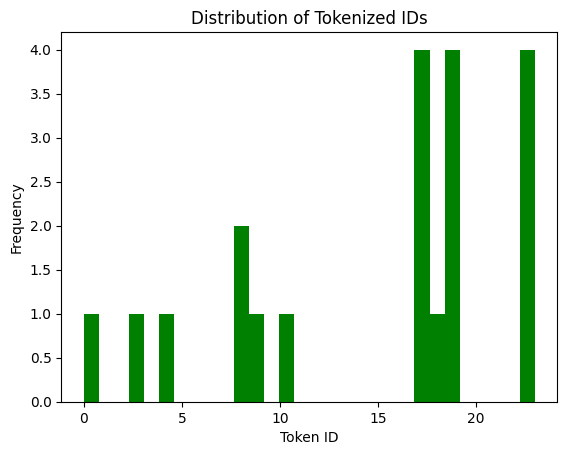

In [21]:
plt.hist(tokenized_data['token_ids'][0][:20], bins=len(my_tokenizer.vocab), color='green')
plt.xlabel('Token ID')
plt.ylabel('Frequency')
plt.title('Distribution of Tokenized IDs')
plt.show()

# Model:


Here is the definition of a <font color="yellow">Collator</font>, which is a function used by the DataLoader to prepare data for training. One of the main problem that we have to solve is the variable length that we may find in our samples. This is solved by applying some <font color="orange">**padding**</font>. In my case the Collator gives me back two tensors:

> <font color="orange">***x_id_pad***</font> which contains all token ids with the relative padding

> <font color="orange">***x_num_pad***</font> which contains all numbers in the position in which x_id_pad has
  the <font color="yellow">[NUM]</font> token id.

In [71]:
"""
Definition of a Collator function to be used by the DataLoader in order to prepare our data for training
"""

def collator(batch):
    # translation to pytorch tensor
    x_id = [torch.tensor(sample['token_ids']) for sample in batch]  # all token ids
    x_num = [torch.tensor(sample['nums']) for sample in batch]      # all original numbers

    # since we have variable length for each simulation, it might be a good idea to extract the maximum one

    max_length = max([len(sample) for sample in x_id])

    # add padding to all samples in order to have them of equal length
    # my_tokenizer.pad_token_id aka 24
    x_id_pad = torch.full((len(batch), max_length), fill_value=my_tokenizer.pad_token_id, dtype=torch.long)
    for idx, sample in enumerate(x_id):
        x_id_pad[idx, :len(sample)] = sample.clone().detach() # copy that sample

    # add padding to all original_numbers in order to have them of equal length
    # when you don't have a number you will have -100
    x_num_pad = torch.full((len(batch), max_length), fill_value=-100, dtype=torch.float)
    for i, sample in enumerate(x_id):     # extract all original number from each sample (row)
        for j, token_id in enumerate(sample):   # extract all numbers from each sample (row)
        # if that value is a number ([NUM] token id = 23) and your index is not out of bounds for the numbers tensor
            if token_id==23 and j < len(x_num[i]):
                x_num_pad[i, j] = x_num[i][j]

    # x_id_pad contains all token ids with padding
    # x_num_pad contains all numbers in the correct position with padding
    return x_id_pad, x_num_pad


train_loader = DataLoader(tokenized_data, batch_size=32, collate_fn=collator, shuffle=True)

All the paper implementations, regardless of the numerical encodings, have used a language model with the main feature as **GPT-2**.
Since all numbers have been replace by the same token <font color="yellow">[NUM]</font> we have lost the information related the Token Head of the model does not carry any information about the number value. A new <font color="orange">***Number Head***</font> with a scalar output is needed to recover the numerical value associated with each istance of the <font color="yellow">[NUM]</font> token.
This means that when the generated token is <font color="yellow">[NUM]</font>, we have to look at the number head to fill the related numerical value.

In [76]:
"""
Since I am interested in the numerical part of the problem, I will use a pre-trained version of GPT2 and includes a numerical head in order to predict
numerical values.
"""

class NumericalHead(torch.nn.Module):
    def __init__(self, gpt2):
        super(NumericalHead, self).__init__()
        self.token_head = gpt2
        self.num_head = torch.nn.Linear(gpt2.config.n_embd, 1)

    def forward(self, x_ids, attention_mask=None):
        output = self.token_head(x_ids, attention_mask=None)
        hidden_states = output.last_hidden_states

        mask = (x_ids == 23).unsqueeze(-1).expand(hidden_states.size())

        hidden_states_masked = hidden_states * mask.float()

        num_preds = self.num_head(hidden_states).squeeze(-1)

        return num_preds

In [96]:
gpt2 = GPT2Model.from_pretrained('gpt2')
gpt2.resize_token_embeddings(len(my_tokenizer))
gpt2.config.n_positions = 1250 # need to change the max length that gpt2 takes, which is set at 1024

In [97]:
num_head = NumericalHead(gpt2)

In [98]:
num_head

NumericalHead(
  (token_head): GPT2Model(
    (wte): Embedding(30, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (num_head): Linear(in_features=768, out_features=1, bias=True)
)

In [ ]:
"""
    Training Loop
"""

optimizer = torch.optim.Adam(num_head.parameters(), lr=1e-4)

for epoch in range(1):
    num_head.train()
    for batch in train_loader:

        x_ids, x_nums = batch

        num_preds = num_head(x_ids)

        # loss computation (use MSE as paper)
        # compute loss only for the numbers --> skip -100
        num_preds = num_preds[x_nums != -100]
        x_nums = x_nums[x_nums != -100]
        loss = torch.nn.MSELoss(num_preds, x_nums)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

In [86]:
gpt2.config.n_embd

768

In [94]:
max([len(sample) for sample in tokenized_data['token_ids']]) # max length that you will find

1250